In [2]:
import numpy as np
from dualtime.src.mclachlan import VarQITE
from gibbs.utils import create_hamiltonian_lattice,printarray,expected_state,state_from_ansatz, simple_purify_hamiltonian,expected_state, create_heisenberg, animated_hamiltonian
from gibbs.preparation.varqite import brute_force_optimization, pauli_rotations_ansatz
from gibbs.preparation.free_energy import brute_cmaes
from qiskit.circuit import ClassicalRegister
from qiskit.opflow import PauliSumOp
from qiskit.quantum_info import SparsePauliOp,Statevector, state_fidelity
from gibbs.learning.hamiltonian_learning import HamiltonianLearning
from gibbs.learning.klocal_pauli_basis import KLocalPauliBasis
from scipy.linalg import expm, logm
from scipy.sparse import vstack
from scipy.linalg import eigh
import matplotlib.pyplot as plt
from matplotlib.animation import FuncAnimation

%load_ext autoreload
%autoreload 2

In [5]:
beta = 1
local_basis = KLocalPauliBasis(k=2,num_qubits=4,periodic=False)
hamiltonian = create_hamiltonian_lattice(4,1/4,-1)
hamiltonian_vec = local_basis.pauli_to_vector(hamiltonian); hamiltonian_vec /= np.linalg.norm(hamiltonian_vec)
hamiltonian = local_basis.vector_to_pauli_op(hamiltonian_vec)
print(hamiltonian)
N = hamiltonian.num_qubits

SparsePauliOp(['XIII', 'IXII', 'IIXI', 'IIIX', 'ZZII', 'IZZI', 'IIZZ'],
              coeffs=[-0.48867778+0.j, -0.48867778+0.j, -0.48867778+0.j, -0.48867778+0.j,
  0.12216944+0.j,  0.12216944+0.j,  0.12216944+0.j])


'circuit-144'

In [216]:

ansatz,x0 = pauli_rotations_ansatz(hamiltonian,depth = 2,entanglement="reverse_linear",su2_gates=["ry"])
varqite = VarQITE(ansatz,x0,backend=None,activate_turbo=True)
steps = 20
result_varqite = varqite.evolve(PauliSumOp(hamiltonian^("I"*N)),beta/2,timestep = beta/(2*steps))
final_state = state_from_ansatz(ansatz,result_varqite.parameters[-1])
theoretical_state = expected_state(hamiltonian,beta = 2*result_varqite.times[-1])
print("We have gotten a gibbs state with fidelity:",state_fidelity(final_state,theoretical_state))

0
0.025
0.05
0.07500000000000001
0.1
0.125
0.15
0.175
0.19999999999999998
0.22499999999999998
0.24999999999999997
0.27499999999999997
0.3
0.325
0.35000000000000003
0.37500000000000006
0.4000000000000001
0.4250000000000001
0.4500000000000001
0.47500000000000014
We have gotten a gibbs state with fidelity: 0.9996096966668844


/home/drudis/python_environements/JulienVarQITE/lib64/python3.10/site-packages/matplotlib/cbook/__init__.py:1369: ComplexWarning: Casting complex values to real discards the imaginary part
  return np.asarray(x, float)


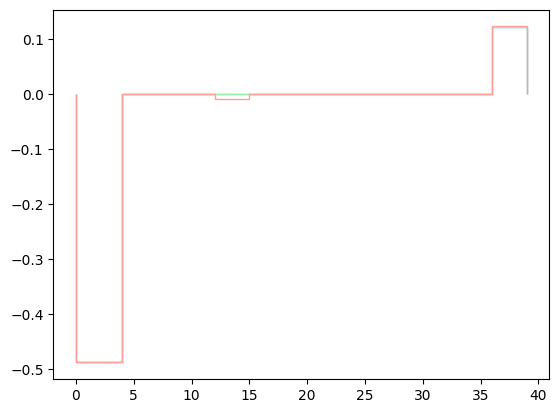

In [217]:
Ks = []
for beta in [1,5,10]:
    state = expected_state(hamiltonian,beta = beta)
    hl = HamiltonianLearning(state,2,3,periodic=False)
    plt.stairs(hl.classical_learn_hamiltonian()[0])
    hl.sample_paulis()
    hl.sampled_paulis *= np.random.normal(1,0.1,hl.sampled_paulis.shape)
    hl.create_constraint_matrix()
    Ks.append(hl.constraint_matrix)
    


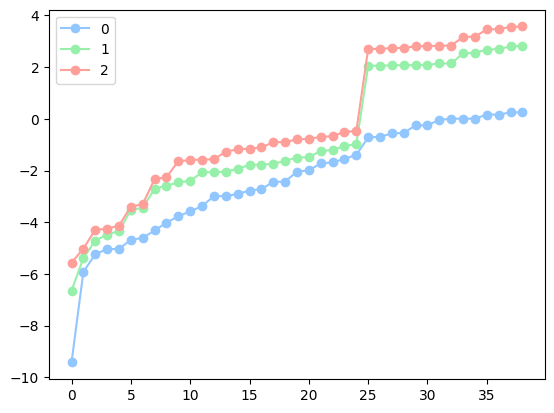

In [218]:
gaps =[]
for i in range(len(Ks)):
    A = vstack(Ks[:i+1])
    ATA = A.T.conj()@A
    eigvals,eigvecs = eigh(ATA.todense())
    gaps.append((eigvals[1]-eigvals[0]))
    plt.plot(np.log(np.abs(eigvals)),label=i,marker="o")
plt.legend()

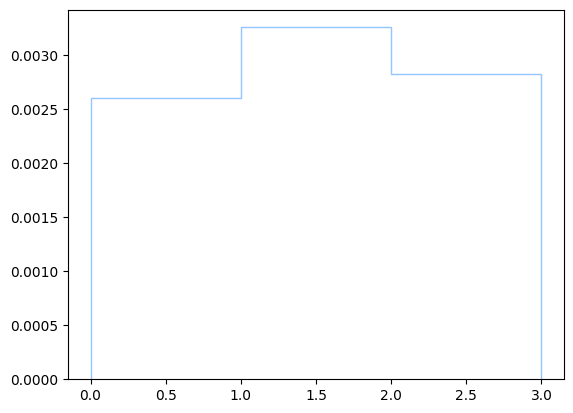

In [219]:
plt.stairs(gaps)